#### Importando bibliotecas

In [276]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster

#### Importando dataset - TUSS 30735068: Artroscopia em Articulacoes do Ombro e Cintura

In [269]:
dataset = pd.read_csv('data/data_30735068.csv', encoding = "ISO-8859-1", delimiter='\',\'', engine='python')

#### Procedimento para agrupar os serviços por id_conta, em formato de string para utilizá-lo no tf-idf.

#### Variáveis:
servicos: lista com todos os serviços existentes no dataset.<br>
serv: lista com os serviços em formato de string, agrupados por id_conta.<br>
contas: ordem das contas utilizadas em serv.

In [270]:
data = list(dataset.servico.groupby(dataset['id_conta']))
servicos = list(dataset.servico.astype(str).value_counts().index)
serv = []
contas = []
for i in range(len(data)):
    serv.insert(i, ' '.join(map(str,data[i][1])))
    contas.append(str(data[i][0]))

#### A idéia por trás desse método é a de que cada linha do dataset seja uma conta e cada coluna um dos serviços existentes no dataset, com seu valor representativo para a conta em questão, baseado na frequência do serviço nessa conta e na frequência com que ele aparece em todo o dataset, valor esse já normalizado.

In [275]:
# exemplo variavel serv
serv[1]

'30735033 30735068 30735033 30735033 30735033 30735033 30735017 30735017 30735033 30735068 30735068 30735017 30735068 30735068 30735017 30735033 30735033 30735017 30735017 30735017 30735068 30735068 30735068 30735033 30735017 30735017 30735068'

#### Utilizando tf-idf(Term Frequency - Inverse Document Frequency) para retornar valores normalizados referente aos serviços utilizados por id_conta.

In [277]:
tfidf = TfidfVectorizer(norm='l2',min_df=0, use_idf=True, smooth_idf=False, sublinear_tf=True, vocabulary=servicos)
X = tfidf.fit_transform(serv).toarray()
X.shape

(362, 3066)

#### A variável X indica que o dataset possui 362 contas diferentes e 3066 serviços distintos, onde para cada um é computando o seu 'peso' normalizado por id_conta.
#### A seguir é usado o método de clusterização por hierarquia, com a métrica de distância escolhida sendo o 'cosine distance'.

In [302]:
X[0]

array([ 0.01970385,  0.02772031,  0.03629033, ...,  0.        ,
        0.        ,  0.        ])

In [301]:
Z = linkage(X, method='complete', metric='cosine')

### Visualizando Z:
Primeira coluna: posição da conta 1.<br>
Segunda coluna: posição da conta 2.<br>
Terceira coluna: distância entre as contas.<br>
Quarta coluna: quantidade de pontos no cluster criado através da junção das duas contas.

In [279]:
Z[:20]

array([[   1.,   46.,    0.,    2.],
       [   2.,    3.,    0.,    2.],
       [   4.,  363.,    0.,    3.],
       [  17.,  364.,    0.,    4.],
       [  10.,   11.,    0.,    2.],
       [  12.,  366.,    0.,    3.],
       [  35.,  367.,    0.,    4.],
       [  42.,  368.,    0.,    5.],
       [  52.,  369.,    0.,    6.],
       [  99.,  370.,    0.,    7.],
       [ 105.,  371.,    0.,    8.],
       [ 120.,  372.,    0.,    9.],
       [ 121.,  373.,    0.,   10.],
       [ 127.,  374.,    0.,   11.],
       [ 142.,  375.,    0.,   12.],
       [ 144.,  376.,    0.,   13.],
       [ 146.,  377.,    0.,   14.],
       [ 147.,  378.,    0.,   15.],
       [ 148.,  379.,    0.,   16.],
       [ 192.,  380.,    0.,   17.]])

#### Utilizando Cophenet Correlation para medir a confiança do dendograma.

In [280]:
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

c, coph_dists = cophenet(Z, pdist(X))
c

0.84704843732868407

#### Plotando o dendograma

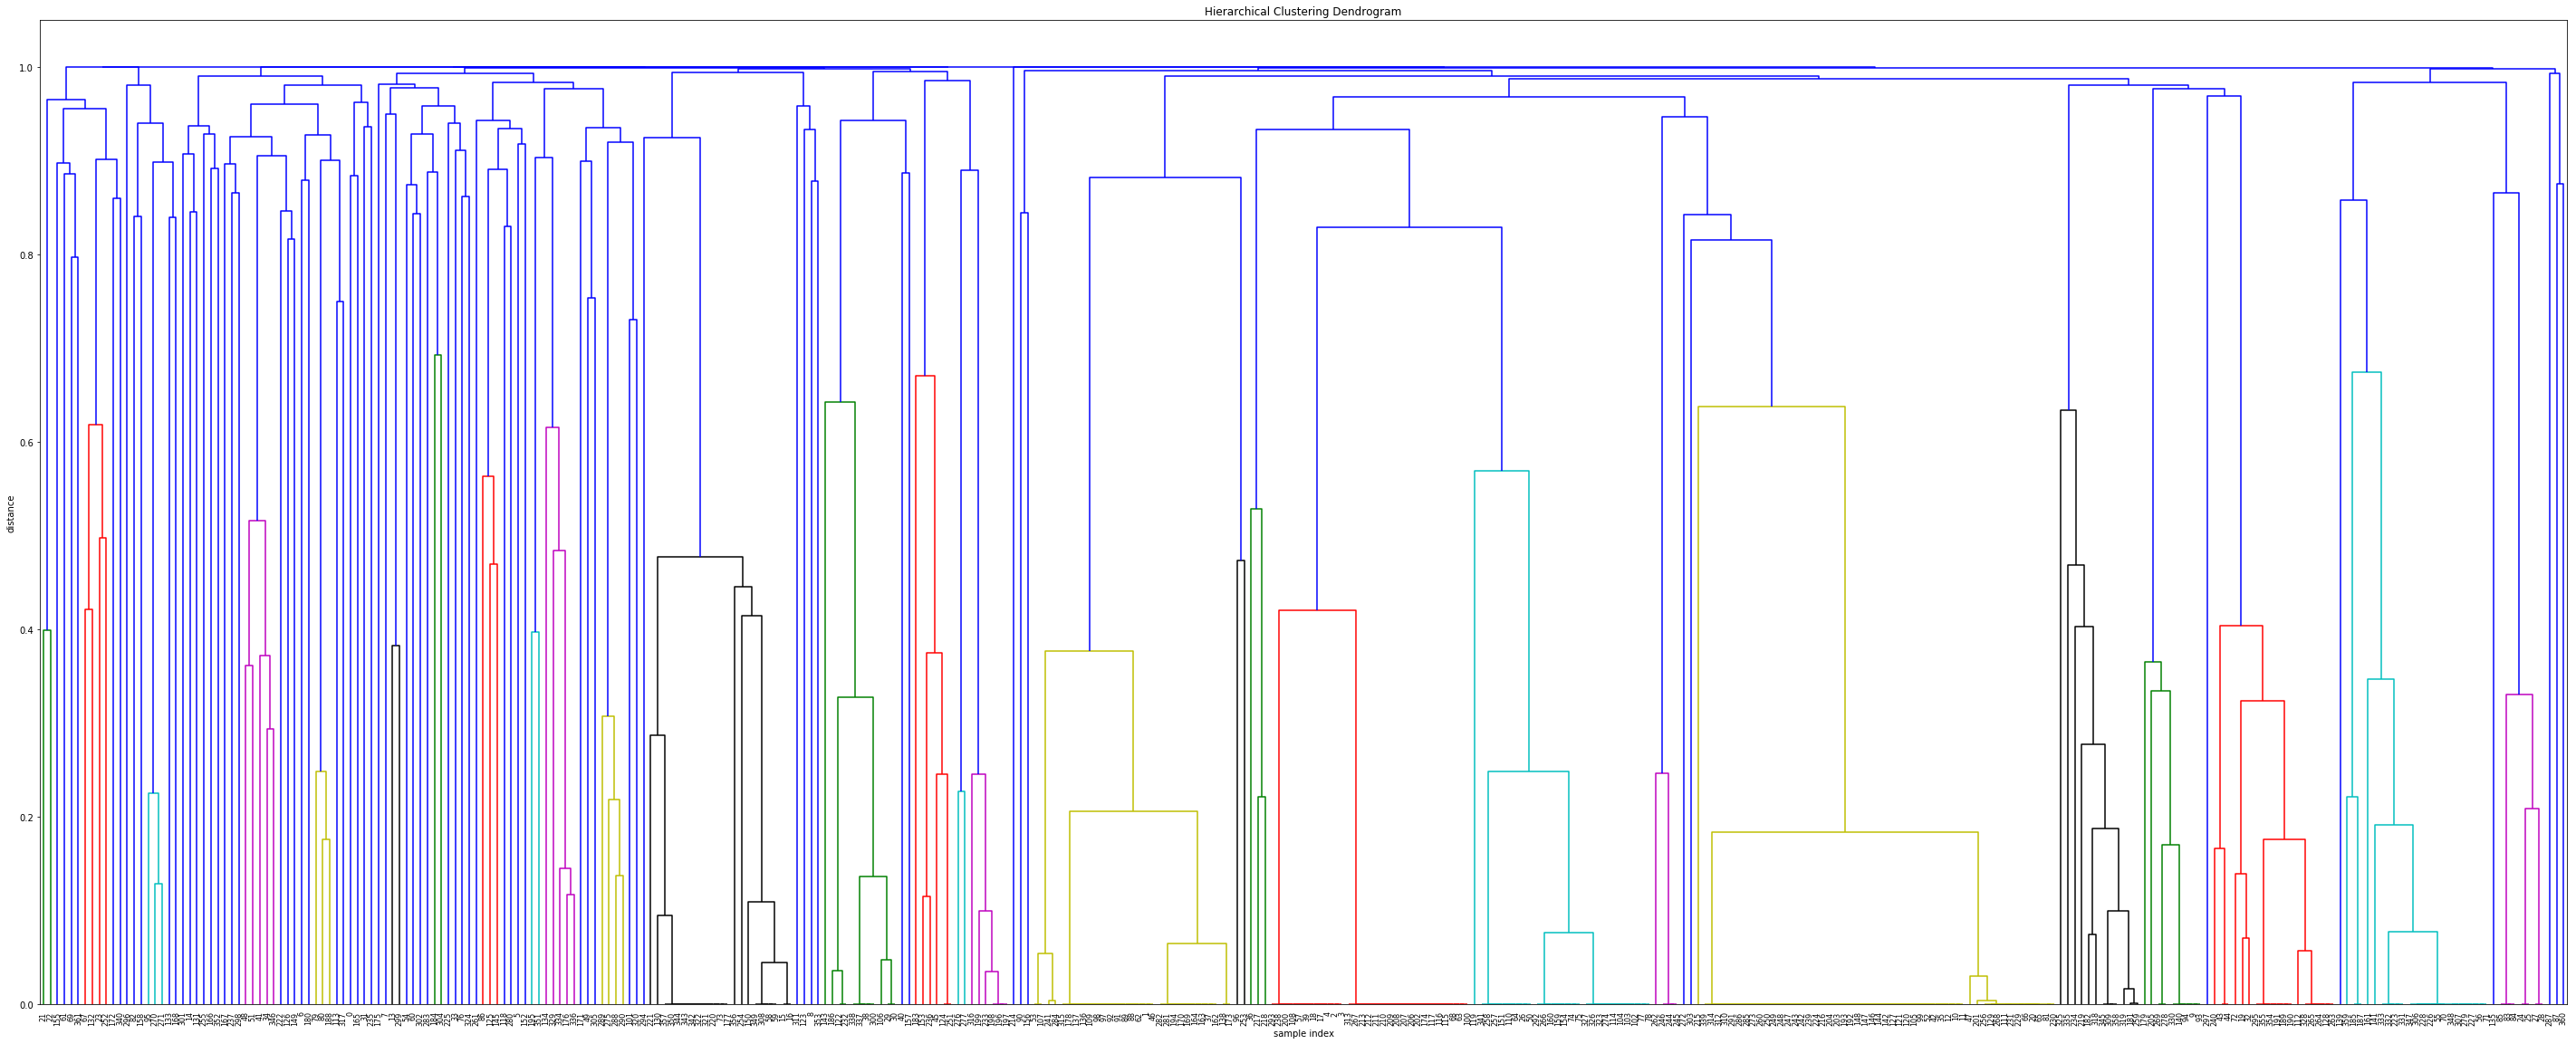

In [298]:
# calculate full dendrogram
plt.figure(figsize=(50, 20))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()

#### Função fancy_dendrograma retirada de:<br> https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/#Perform-the-Hierarchical-Clustering

In [282]:
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

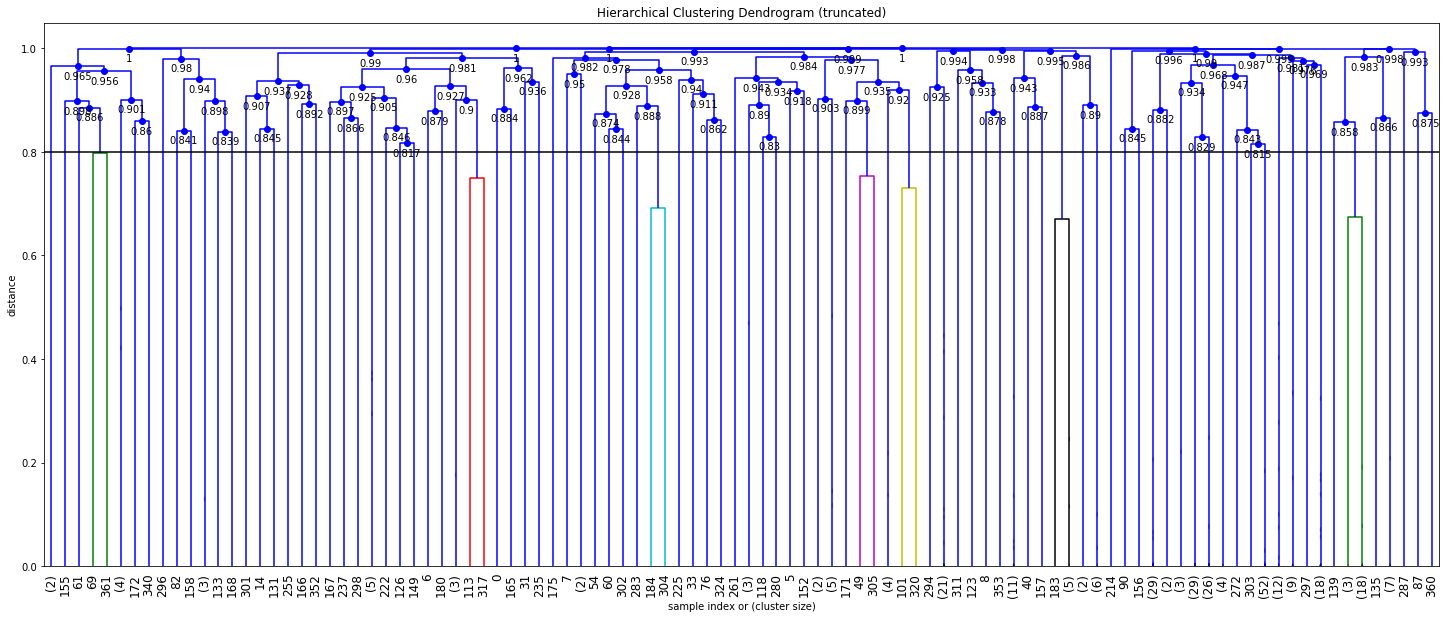

In [284]:
plt.figure(figsize=(25, 10))
fancy_dendrogram(
    Z,
    truncate_mode='lastp',
    p=100,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=0.8,  # useful in small plots so annotations don't overlap
    max_d=0.8
)
plt.show()

#### Criando os clusters utilizando como métrica a distância máxima entre os pontos de 0.5, devido a dificuldade de escolher um número ideal de clusters.

In [285]:
clusters = fcluster(Z, 0.5, 'distance')
clusters

array([ 35,  84,  88,  88,  88,  56,  30,  40,  70,  98,  92,  92,  92,
        39,  16,  68,  68,  88,  88,  99,  92,   1,   1,   7, 104, 104,
        89, 104, 104,  74,  74,  37,  99,  49,  26,  92,  87,  84,  74,
        88,  76,  26,  92,  99,  99,  78,  84,  92,  25,  62,  89,  25,
        92,  84,  43, 102, 102,  88,  68,  68,  41,   4,  84,  88,  89,
        92,  92,   6,  88,   2, 102, 102,  99,  68,  89,  89,  47,  89,
        89,  32,  32,  92,  10, 104, 104, 104,  53, 106,  84,  84,  82,
        84,  84,  98,  98,  12,  85,  84,  84,  92,  88,  66,  89,  89,
        89,  92,  74,  84,  88,  84,  89,  92,  99,  33,  89,  88,  88,
        88,  54,  90,  92,  92,  74,  72,  78,  52,  27,  92,  99,  92,
        68,  17,   6,  13,  61, 105,  84,  84,  84, 103,  98, 102,  92,
        75,  92,  52,  92,  92,  92,  28,  68,  89,  57,  78,  89,   5,
        83,  77,  11,  89,  89, 102,  84,  84,  84,  36,  19,  24,  14,
        84,  84,  64,   8,  84,  88,  51,  60,  68,  84,  98,  3

#### Número de clusters criados:

In [287]:
clusters.max()

109

#### Criando dataframe do resultado dos clusters.

In [288]:
result = pd.DataFrame(X, columns=servicos)
contas = pd.DataFrame(contas, columns=['conta'])
result.set_index(contas.conta, inplace=True)
result['cluster'] = clusters
result.head(5)

,30735068,30735033,30735084,30735092,90196031,30735017,70014370,90008332,70705330,30717140,...,00633078,00000943,09090426,0000137108,90189590,08020960,0000049571,00028609,0070034427,cluster
conta,,,,,,,,,,,,,,,,,,,,,
1135496119.0,0.019704,0.027720,0.03629,0.0,0.0,0.000000,0.0,0.098744,0.0,0.0,...,0.0,0.0,0.0,0.135792,0.0,0.0,0.0,0.0,0.0,35
1135529130.0,0.285949,0.402286,0.00000,0.0,0.0,0.869712,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,84
1135539516.0,1.000000,0.000000,0.00000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,88
1135539699.0,1.000000,0.000000,0.00000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,88
1135539701.0,1.000000,0.000000,0.00000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,88


#### Procurando cluster com mais contas atreladas.

In [289]:
result.cluster.value_counts()[:10]

92     51
88     29
84     29
89     25
68     21
102    18
99     18
96     11
74     10
98      9
Name: cluster, dtype: int64

#### Imprimindo o número de serviços existentes no cluster 92 e a média de sua importância.

In [290]:
for servico in list(filter(lambda x: x != 'cluster', result.columns)):
    if(result[servico].loc[result.cluster==92].max() > 0):
        print('Servico: %s,  Média: %.2f' % (servico, result[servico].loc[result.cluster==83].mean()))

Servico: 30735068,  Média: 0.05
Servico: 30735033,  Média: 0.00
Servico: 30735084,  Média: 0.00


#### Pegando os serviços das contas do cluster 92 pelo dataset original, de forma a contar o número dos serviços total existentes.

In [299]:
dataset.id_conta = dataset.id_conta.astype(str)
grupo = []

for conta in result.loc[result.cluster==92].index:
     grupo.append(list(dataset['servico'].loc[dataset.id_conta==conta]))

grupo = np.concatenate(grupo)
grupo = pd.DataFrame(grupo,columns=['servico'])
grupo.servico.value_counts()

30735084    99
30735068    98
30735033    49
Name: servico, dtype: int64

#### Descrição de cada serviço do cluster:
30735084: RESSECCAO LATERAL DE CLAVICULA, aparece 99 vezes(TUSS PRINCIPAL).<br>
30735068: RUPTURA DO MANGUITO ROTADOR, aparece 98 vezes.<br>
30735033: ACROMIOPLASTIA, aparece 49 vezes.

In [297]:
dataset.descricao_despesa.loc[dataset.servico=='30735084'].head(20)

63                      RessecÃ§Ã£o Lateral Da ClavÃ­cula
750                        RESSECCAO LATERAL DA CLAVICULA
753                        RESSECCAO LATERAL DA CLAVICULA
758                        RESSECCAO LATERAL DA CLAVICULA
802     RESSECCAO LATERAL DA CLAVICULA - PROCEDIMENTO ...
882     RESSECCAO LATERAL DA CLAVICULA - PROCEDIMENTO ...
883     RESSECCAO LATERAL DA CLAVICULA - PROCEDIMENTO ...
888     RESSECCAO LATERAL DA CLAVICULA - PROCEDIMENTO ...
1011    Resseccao lateral da clavicula - procedimento ...
1068                     RESSECÃÃO LATERAL DA CLAVICULA
1073                       RESSECCAO LATERAL DE CLAVICULA
1077                       RESSECCAO LATERAL DE CLAVICULA
1078                       RESSECCAO LATERAL DE CLAVICULA
1080                       RESSECCAO LATERAL DE CLAVICULA
1518                       RESSECCAO LATERAL DA CLAVICULA
1519                       RESSECCAO LATERAL DA CLAVICULA
1520                       RESSECCAO LATERAL DA CLAVICULA
1569          

In [296]:
dataset.descricao_despesa.loc[dataset.servico=='30735068'].head(20)

33                           Ruptura Do Manguito Rotador
76                        LESAO MANGUITO ROTADOR    (IT)
84                                        INSTRUMENTADOR
85                                        INSTRUMENTADOR
87                                            1 AUXILIAR
88                        LESAO MANGUITO ROTADOR    (IT)
95                                        INSTRUMENTADOR
96                                            1 AUXILIAR
97                                            1 AUXILIAR
101                       LESAO MANGUITO ROTADOR    (IT)
102    RUPTURA DO MANGUITO ROTADOR - PROCEDIMENTO VID...
103    RUPTURA DO MANGUITO ROTADOR - PROCEDIMENTO VID...
104    RUPTURA DO MANGUITO ROTADOR - PROCEDIMENTO VID...
105    RUPTURA DO MANGUITO ROTADOR - PROCEDIMENTO VID...
106    RUPTURA DO MANGUITO ROTADOR - PROCEDIMENTO VID...
107    RUPTURA DO MANGUITO ROTADOR - PROCEDIMENTO VID...
183    Ruptura do manguito rotador - procedimento vid...
310    RUPTURA DO MANGUITO ROTA

In [295]:
dataset.descricao_despesa.loc[dataset.servico=='30735033'].head(20)

38                     Acromioplastia
75                         1 AUXILIAR
77                     INSTRUMENTADOR
78                     INSTRUMENTADOR
79     ACROMIOPLASTIA            (NO)
80     ACROMIOPLASTIA            (NO)
83                         1 AUXILIAR
90                     INSTRUMENTADOR
91     ACROMIOPLASTIA            (NO)
98                         1 AUXILIAR
448                    Acromioplastia
484                    Acromioplastia
485                    Acromioplastia
491                    Acromioplastia
492                    Acromioplastia
529                    Acromioplastia
572                    Acromioplastia
577                    Acromioplastia
609                    Acromioplastia
752                    ACROMIOPLASTIA
Name: descricao_despesa, dtype: object